# Sentiment Analysis on the Movie Reviews corpus available in NLTK. 
This code explains how to use a combination of bigrams and unigrams as features to determine the sentiment of movie reviews.
This code is written using the help of a series of articles by Streamhacker on Text Classification, the first one being http://streamhacker.com/2010/05/10/text-classification-sentiment-analysis-naive-bayes-classifier/

In [21]:
from nltk.corpus import movie_reviews
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
import collections
from nltk.probability import FreqDist, ConditionalFreqDist
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [22]:
def movie_classifier(features):
    
    #Seperate into positive and negative ids
    pos_ids=movie_reviews.fileids('pos')
    neg_ids=movie_reviews.fileids('neg')
    
    #Extract features from the corpus (unigrams and bigrams)
    negfeats = [(features(movie_reviews.words(fileids=[f])), 'neg') for f in neg_ids]
    posfeats = [(features(movie_reviews.words(fileids=[f])), 'pos') for f in pos_ids]
    
    #Calculation of test and training data
    neg_split=len(negfeats)*3/4
    pos_split=len(posfeats)*3/4
    
    #Split it into test and train data
    train_data = negfeats[:neg_split]+posfeats[:pos_split]
    test_data = negfeats[neg_split:]+posfeats[pos_split:]
    
    print "Training data comprises of %d files and Test data comprises of %d files" %(len(train_data),len(test_data))
    
    classifier = NaiveBayesClassifier.train(train_data)
    
  
    reference_output = collections.defaultdict(set)
    test_output = collections.defaultdict(set)
    
    for i, (feats, label) in enumerate(test_data):
        reference_output[label].add(i)
        observed = classifier.classify(feats)
        test_output[observed].add(i)
        
    #For calculation of accuracy  
    print 'accuracy:', nltk.classify.util.accuracy(classifier, test_data)
    print 'pos precision:', nltk.metrics.precision(reference_output['pos'], test_output['pos'])
    print 'pos recall:', nltk.metrics.recall(reference_output['pos'], test_output['pos'])
    print 'neg precision:', nltk.metrics.precision(reference_output['neg'], test_output['neg'])
    print 'neg recall:', nltk.metrics.recall(reference_output['neg'], test_output['neg'])
    classifier.show_most_informative_features()

In [23]:
word_fd = FreqDist()
label_word_fd = ConditionalFreqDist()
for word in movie_reviews.words(categories=['pos']):
    word_fd[word.lower()]+=1
    label_word_fd['pos'][word.lower()]+=1
    
for word in movie_reviews.words(categories=['neg']):
    word_fd[word.lower()]+=1
    label_word_fd['neg'][word.lower()]+=1
    
pos_word_count = label_word_fd['pos'].N()
neg_word_count = label_word_fd['neg'].N()
total_word_count = pos_word_count + neg_word_count


word_scores = {}
# Calculating important words for each category and merging their score to find the most important single word feature
for word, freq in word_fd.iteritems():
    pos_score = BigramAssocMeasures.chi_sq(label_word_fd['pos'][word],(freq, pos_word_count), total_word_count)
    neg_score = BigramAssocMeasures.chi_sq(label_word_fd['neg'][word],(freq, neg_word_count), total_word_count)
    word_scores[word] = pos_score + neg_score

# Top 10000 words as features 
best = sorted(word_scores.iteritems(), key=lambda (w,s): s, reverse=True)[:10000]
bestwords = set([w for w, s in best])

def best_word_feats(words):
    return dict([(word, True) for word in words if word in bestwords])

# Adding top 200 bigrams also as features
def best_bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    d = dict([(bigram, True) for bigram in bigrams])
    d.update(best_word_feats(words))
    return d
 
print 'evaluating best words + bigram chi_sq word features'
movie_classifier(best_bigram_word_feats)

evaluating best words + bigram chi_sq word features
Training data comprises of 1500 files and Test data comprises of 500 files
accuracy: 0.92
pos precision: 0.913385826772
pos recall: 0.928
neg precision: 0.926829268293
neg recall: 0.912
Most Informative Features
             magnificent = True              pos : neg    =     15.0 : 1.0
             outstanding = True              pos : neg    =     13.6 : 1.0
               insulting = True              neg : pos    =     13.0 : 1.0
              vulnerable = True              pos : neg    =     12.3 : 1.0
     (u'matt', u'damon') = True              pos : neg    =     12.3 : 1.0
        (u'give', u'us') = True              neg : pos    =     12.3 : 1.0
               ludicrous = True              neg : pos    =     11.8 : 1.0
             uninvolving = True              neg : pos    =     11.7 : 1.0
                  avoids = True              pos : neg    =     11.7 : 1.0
  (u'absolutely', u'no') = True              neg : pos    =  

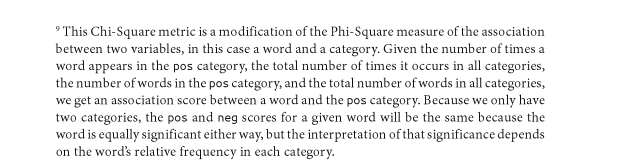

In [24]:
from IPython.display import Image
Image(filename='chi_sq.PNG')